In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

## Trial 1

In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size= 10000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [ ]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv

# training_cleaned.csv
!gdown --id 1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ

num_sentences = 0

with open("./training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        
        ### START CODE HERE
        list_item.append(row[5])
        label_val = 0 if row[0] == '0' else 1
        list_item.append(label_val)
        #Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
        # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        ### END CODE HERE
        
        num_sentences = num_sentences + 1
        corpus.append(list_item)


Downloading...
From: https://drive.google.com/uc?id=1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ
To: /content/training_cleaned.csv
100% 239M/239M [00:03<00:00, 63.6MB/s]


In [ ]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [ ]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding = padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
test_labels = labels[:split]
training_labels = labels[split:]

In [ ]:
set(labels)

{0, 1}

In [ ]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138856
# 1

19226
1


In [ ]:
# Note this is the 100 dimension version of GloVe from Stanford

# glove.6B.100d.txt
!gdown --id 1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g

embeddings_index = {};
with open('./glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

Downloading...
From: https://drive.google.com/uc?id=1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g
To: /content/glove.6B.100d.txt
 29% 99.6M/347M [00:01<00:02, 89.5MB/s]

In [ ]:
print(len(embeddings_matrix))
# Expected Output
# 138857

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

num_epochs = 50
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, validation_data=(test_sequences, np.array(test_labels)), verbose=2)

print("Training Complete")


<Figure size 432x288 with 0 Axes>

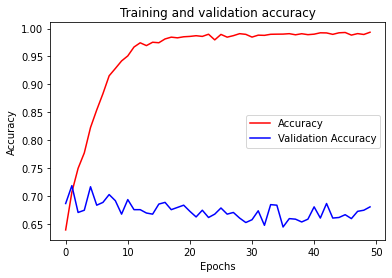

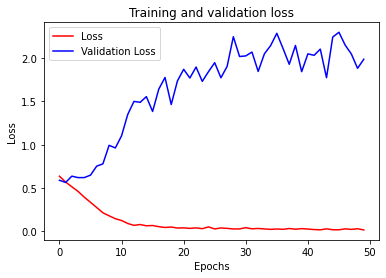

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

## Trial 2

In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size= 160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [ ]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv

# training_cleaned.csv
!gdown --id 1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ

num_sentences = 0

with open("./training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        
        ### START CODE HERE
        list_item.append(row[5])
        label_val = 0 if row[0] == '0' else 1
        list_item.append(label_val)
        #Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
        # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        ### END CODE HERE
        
        num_sentences = num_sentences + 1
        corpus.append(list_item)


Downloading...
From: https://drive.google.com/uc?id=1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ
To: /content/training_cleaned.csv
100% 239M/239M [00:02<00:00, 91.8MB/s]


In [ ]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [ ]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding = padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
test_labels = labels[:split]
training_labels = labels[split:]

In [ ]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138856
# 1

138409
1


In [ ]:
# Note this is the 100 dimension version of GloVe from Stanford

# glove.6B.100d.txt
!gdown --id 1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g

embeddings_index = {};
with open('./glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

Downloading...
From: https://drive.google.com/uc?id=1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g
To: /content/glove.6B.100d.txt
100% 347M/347M [00:04<00:00, 75.1MB/s]


In [ ]:
print(len(embeddings_matrix))
# Expected Output
# 138857

138410


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

num_epochs = 50
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, validation_data=(test_sequences, np.array(test_labels)), verbose=2)

print("Training Complete")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16, 100)           13542400  
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 64)            32064     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,607,553
Trainable params: 65,153
Non-trainable params: 13,542,400
_________________________________________________________________
Epoch 1/50
4500/4500 - 25s - loss: 0.5295 - accuracy: 0.7469 - val_loss: 0.5079 - val_accuracy: 0.7532 - 25s/epoch - 6ms/step
Epoch 2/50
4500/4500 - 23s - loss: 0.5096 -

<Figure size 432x288 with 0 Axes>

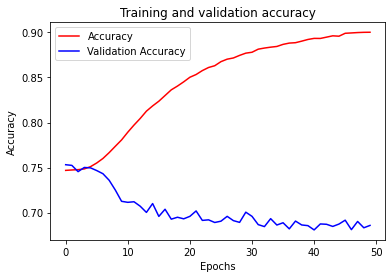

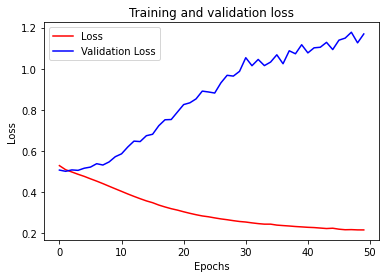

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

## Trial 3

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

num_epochs = 15
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, validation_data=(test_sequences, np.array(test_labels)), verbose=2)

print("Training Complete")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 16, 100)           13542400  
                                                                 
 dropout_3 (Dropout)         (None, 16, 100)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 12, 64)            32064     
                                                                 
 dropout_4 (Dropout)         (None, 12, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,607,553
Trainable params: 65,153
Non-

<Figure size 432x288 with 0 Axes>

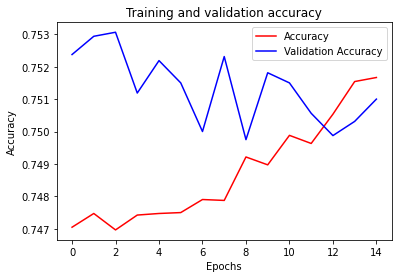

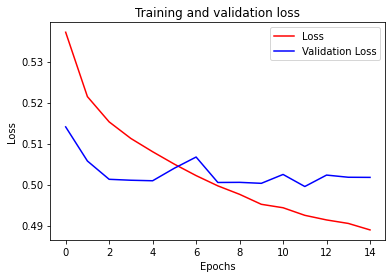

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

## Trial 4

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

num_epochs = 15
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, validation_data=(test_sequences, np.array(test_labels)), verbose=2)

print("Training Complete")


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 16, 100)           13542400  
                                                                 
 dropout_5 (Dropout)         (None, 16, 100)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 12, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                      

<Figure size 432x288 with 0 Axes>

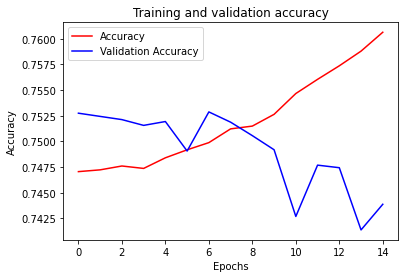

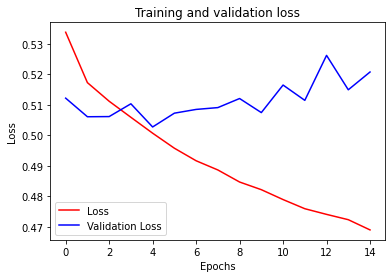

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

## Trial 5

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

num_epochs = 15
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, validation_data=(test_sequences, np.array(test_labels)), verbose=2)

print("Training Complete")


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 16, 100)           13542400  
                                                                 
 dropout_8 (Dropout)         (None, 16, 100)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 12, 64)            32064     
                                                                 
 lstm_8 (LSTM)               (None, 12, 256)           328704    
                                                                 
 dropout_9 (Dropout)         (None, 12, 256)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                82176     
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

## Trial 6

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.LSTM(512, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

num_epochs = 30
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, validation_data=(test_sequences, np.array(test_labels)), verbose=2)

print("Training Complete")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           13870500  
                                                                 
 dropout (Dropout)           (None, 16, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 12, 128)           64128     
                                                                 
 lstm (LSTM)                 (None, 12, 512)           1312768   
                                                                 
 dropout_1 (Dropout)         (None, 12, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 256)           787456    
                                                                 
 dropout_2 (Dropout)         (None, 12, 256)           0

<Figure size 432x288 with 0 Axes>

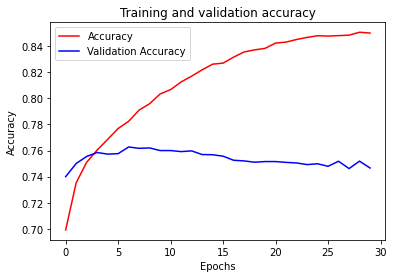

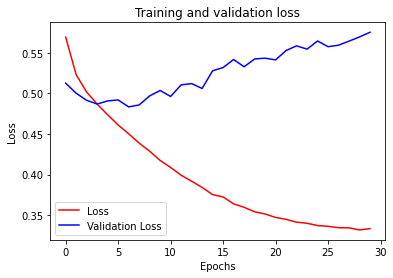

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

## Trial 7

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

num_epochs = 30
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, validation_data=(test_sequences, np.array(test_labels)), verbose=2)

print("Training Complete")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           13870500  
                                                                 
 dropout (Dropout)           (None, 16, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 12, 128)           64128     
                                                                 
 bidirectional (Bidirectiona  (None, 12, 1024)         2625536   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 12, 1024)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 12, 512)          2623488   
 nal)                                                   

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

## Trial 8

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])


In [ ]:
BATCH_SIZE=1024
STEPS_PER_EPOCH = training_sequences.shape[0]//BATCH_SIZE
print(f'STEPS PER EPOCH: {STEPS_PER_EPOCH}')

STEPS PER EPOCH: 140


In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH * 10,
    decay_rate=1,
    staircase = False
    )

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
callbacks = [es]

In [ ]:
model.compile(loss='binary_crossentropy', 
              metrics=['accuracy'], 
              optimizer=tf.keras.optimizers.Adam(lr_scheduler))
model.summary()

num_epochs = 50
history = model.fit(training_sequences, 
                    np.array(training_labels), 
                    batch_size = BATCH_SIZE,
                    epochs=num_epochs, 
                    validation_data=(test_sequences, np.array(test_labels)), 
                    callbacks = callbacks,
                    verbose=2)

print("Training Complete")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           13841000  
                                                                 
 dropout (Dropout)           (None, 16, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 12, 128)           64128     
                                                                 
 bidirectional (Bidirectiona  (None, 12, 512)          788480    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 12, 512)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 12, 256)          656384    
 nal)                                                   

<Figure size 432x288 with 0 Axes>

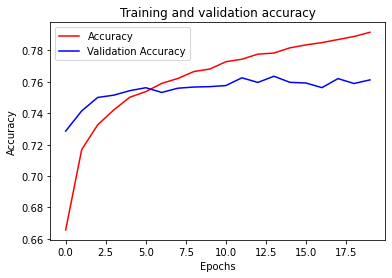

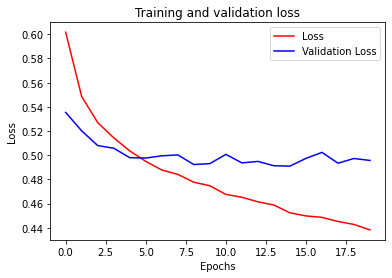

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!